Import of basic libraries:

In [3]:
import pandas as pd
import numpy as np
import math
from numpy import sqrt, radians, arcsin, sin, cos
import matplotlib.pyplot as plt

Classes from 'geospatial':

In [4]:
####### Point #######

class Point():
    # initialise
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    # representation
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'

        # Test for equality between Points
    def __eq__(self, other): 
        if not isinstance(other, Point):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.x == other.x and self.y == other.y

    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.x, self.y))
    
    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    # calculate Manhattan distance between two points
    def distManhattan(self, other):
        return abs(self.x-other.x) + abs(self.y-other.y)

    # Haversine distance between two points on a sphere - requires lat/lng converted to radians
    def distHaversine(self, other):
        r = 6371000  # Earth's radius in metres (will return result in metres)
        phi1 = radians(self.y) # latitudes
        phi2 = radians(other.y)
        lam1 = radians(self.x) # longitudes
        lam2 = radians(other.x)

        d = 2 * r * arcsin(sqrt(sin((phi2 - phi1)/2)**2 + 
                                      cos(phi1) * cos(phi2) * sin((lam2 - lam1)/2)**2))
        return d   

    
    # Calculate determinant with respect to three points. Note the order matters here - we use it to work out left/ right in the next method
    def __det(self, p1, p2):
        det = (self.x-p1.x)*(p2.y-p1.y)-(p2.x-p1.x)*(self.y-p1.y)       
        return det

    def leftRight(self, p1, p2):
        # based on GIS Algorithms, Ch2, p11-12, by Ningchuan Xiao, publ. 2016
        # -ve: this point is on the left side of a line connecting p1 and p2
        #   0: this point is collinear
        # +ve: this point is on the right side of the line
        side = int(self.__det(p1, p2))
        if side != 0:
            side = side/abs(side)  # will return 0 if collinear, -1 for left, 1 for right
        return side

In [5]:
####### Segment #######
class Segment():    
    # initialise
    def __init__(self, p0, p1):
        self.start = p0
        self.end = p1
        self.length = p0.distEuclidean(p1)
    
    # representation
    def __repr__(self):
        return f'Segment with start {self.start} and end {self.end}.' 

    # Test for equality between Segments - we treat segments going in opposite directions as equal here
    def __eq__(self, other): 
        if (self.start == other.start or self.start == other.end) and (self.end == other.end or self.end == other.start):
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries
    
    def __hash__(self):
        return hash((self.start.x, self.start.y,self.end.x, self.end.y))    
        
    # determine if intersects with another segment (using Point method leftRight)
    # - should we incorporate testing for identical segments and non-zero lengths?
    def intersects(self, other):        
        # create bounding boxes for each segment, using Bbox class
        self_bbox = Bbox(self)
        other_bbox = Bbox(other)

        # test if bounding boxes overlap (using Bbox method testOverlap)
        bbox_overlap = self_bbox.intersects(other_bbox)
               
        # if the two bboxes do not overlap, there can be no intersection        
        if bbox_overlap == False:
            return False
        
        else: # bboxes overlap, test if lines intersect or are collinear
            
            # find side for each point of each line in relation to the points of the other line
            apq = self.start.leftRight(other.start, other.end)
            bpq = self.end.leftRight(other.start, other.end)
            pab = other.start.leftRight(self.start, self.end)
            qab = other.end.leftRight(self.start, self.end)           
            
            # leftRight sums to 0 for both segments if they intersect (+1/-1) or are collinear (0/0)
            if (apq + bpq == 0 and pab + qab == 0): 
                return True
            else:
                return False   

In [6]:
## new test class ##
class LineString:
    def __init__(self, points):
        self.points = points
 
    def intersects(self, segment):
        return segment.intersects(self.points)

In [7]:
def buffer_points(points, buffer_size):
    """
    Buffer points with buffer size.
    
    inputs
      - points: list of tuples, each containing x and y coordinates
      - buffer_size: float, the size of the buffer radius
      
    output
      - list of points
    """
    buffered_points = []
    for point in points:
        x = point.x
        y = point.y
        
        # Create a circle of points around the original point
        angles = np.linspace(0, (2-2/50)*np.pi, num=10)
        circle_points = [Point(x + buffer_size*np.cos(a), y + buffer_size*np.sin(a)) for a in angles]
        
        buffered_points += circle_points
    
    return buffered_points

#### ConcaveHull Class

This concave hull is copied and modified from: https://github.com/M-Lin-DM/Concave-Hulls/blob/master/hulls.py
The principle can be seen on here: https://towardsdatascience.com/the-concave-hull-c649795c0f0f

The code is not yet working, as the creator used shapely in order to test the polygon on self intersection. Additionally, input for this class is expected to be an array of arrays or a list of lists. The code is not yet fully modified to work with our data structures.

In [64]:
class ConcaveHull:
    
    #SOME THINGS IN INIT NOT COPIED (MAINLY DATA PREP)
    def __init__(self, points, k):
        #renamed! is called 'data_set' in github
        self.point_list = np.array(points)
        self.coords = np.array([[point.x,point.y] for point in points])
        #copied
        self.indices = np.ones_like(self.coords, dtype=int)
        self.k = k
        
    # Changed to use Euclidean dist    
    @staticmethod
    def dist_pt_to_group(point_a, point_b):  # a is a (n,2) , b is (1,2) arrays
        d = list(map(lambda p: p[0].distEuclidean(point_b), point_a))
        return d
    
    #16.05.2023 12:51: Altered, adjusted for work with point class instances
    #CV 23.05.2023: Changed back to original
    @staticmethod
    def get_lowest_latitude_index(points):
        """
        Sorts a list of points based on their y-value and returns it.
        """
        indices = np.argsort(points[:, 1])
        return indices[0]
    
    #ONLY COPIED YET
    @staticmethod
    def norm_array(v):  # normalize row vectors in an array. observations are rows
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    #ONLY COPIED YET
    @staticmethod
    def norm(v):  # normalize a single vector, is there an existing command?
        norms = np.array(np.sqrt(np.sum(np.square(v))))
        return v / norms
    
    #ADJUSTED: TAKE ARRAY OF POINTS INSTEAD OF 2D ARR    
    def get_k_nearest(self, i_startpoint, k):
        
        idxs = self.indices
        #creates an array of length of all still active 
        #nodes, and assignes their respective indices to them.
        base_indices = np.arange(len(idxs))[idxs]
        distances = self.dist_pt_to_group(self.point_list[idxs],self.point_list[i_startpoint])
        sort_ind = np.argsort(distances)
        kk = min(k, len(sort_ind))
        knn = sort_ind[range(kk)]
        return base_indices[knn]
    
    #ONLY COPIED YET
    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  # normalized vector pointing towards previous point
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  # normalized row vectors pointing to set of k nearest neibs
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            # ang[j,0] = theta
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            # ang[j,2] = z
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)
    
    
    #ONLY COPIED YET
    def recurse_calculate(self):
        """
        Calculates the concave hull using the next value for k while reusing the distances dictionary
        :return: Concave hull
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            print(" max k reached, at k={0}".format(recurse.k))
            return None
        print("k={0}".format(recurse.k))
        return recurse.calculate()
    
    #IN ADJUSTEMENT
    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        #if the line string contains less than 3 points, then quit
        #adjusted -> size instead of shape of one dimension
        if self.coords.size < 3:
            return None

        #if the line string contains exactly 3 points then return the nodes
        #adjusted -> size instead of shape of one dimension
        if self.coords.size == 3:
            return self.coords

        # Make sure that k neighbors can be found
        # So if k (num neighbours) was smaller than the length of the data, then the data len is returned
        kk = min(self.k, self.coords.size)
        
        #16.05.2023: looking at the get_lowest_latitude
        #16.05.2023 12.51: get_lowest_latitude is adjusted
        first_point = self.get_lowest_latitude_index(self.coords)
        
        #the first_point is the one most 'left'
        current_point = first_point
        
        #original comment: # last_point = current_point # not sure if this is necessary since it wont get used until after step 2

        #original comment: # Note that hull and test_hull are matrices (N, 2)
        
        #hull and test_hull are created as arrays, containing the first point from the beginning
        hull = np.array([self.point_list[first_point]])
        test_hull = hull

        #original comment # Remove the first point
        self.indices[first_point] = False
        
        #dont know what this step/stop means 
        step = 2
        stop = 2 + kk

        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  # last condition counts number of ones, points in dataset
            if step == stop:
                self.indices[first_point] = True
            
            #original comment# notice how get_k_nearest doesnt take the data set directly as an arg, as it is implicit that it takes self as an imput because we are inside a class:
            knn = self.get_k_nearest(current_point, kk)  # knn = [3,6,2] or [0,2,7] etc indicies into the full dataset (with no points removed)

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                #original comment: # Calculates the headings between first_point and the knn points
                #original comment: # Returns angles in the same indexing sequence as in knn
                #16.05.2023 13.05: Changed last_point to first_point (don't know if its right)
                #clockwise_angles not yet adjusted!
                angles = self.clockwise_angles(first_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first). candidates =[0,1,2]  or [2,1,0] etc if kk=3
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True
            
            #while executes if invalid_hull is true and there are candidates
            while invalid_hull and i < len(candidates):
                #take the first candidate
                candidate = candidates[i]

                #original comment: # Create a test hull to check if there are any self-intersections
                next_point = (self.data_set[knn[candidate]])
                test_hull = np.append(hull, next_point, axis=0)
                
                #insted of using the inbuilt function, we have to include our own method here
                line = asLineString(test_hull)
                invalid_hull = not line.is_simple  # invalid_hull will remain True for every candidate which creates a line that intersects the hull. as soon as the hull doesnt self intersect, it will become false and the loop will terminate
                i += 1

            if invalid_hull:
                print("invalid hull for all nearest neibs")
                return self.recurse_calculate()

            last_point = current_point  # record last point for clockwise angles
            current_point = knn[candidate] # candidate = 0, 1, or 2 if kk=3
            hull = test_hull

            self.indices[current_point] = False # we remove the newly found current point from the "mask" indicies so that it wont be passed to get_k_nearest (within the implicit input, self)
            step += 1

        poly = Polygon(hull)

        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            pt = Point(self.data_set[ix, :])
            if poly.intersects(pt) or pt.within(poly):
                count += 1
            else:
                print("point not in polygon")

        if count == total:
            return hull
        else:
            return self.recurse_calculate()

Visualization of Point Buffers

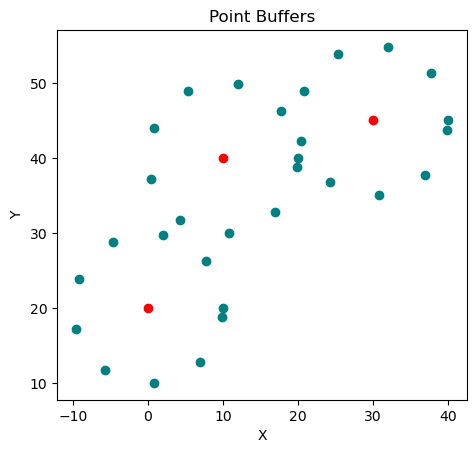

In [27]:
seed_points = [Point(0,20), Point(10,40), Point(30,45)]
point_buffer = buffer_points(seed_points, 10)

xs = [i.x for i in point_buffer]
ys = [i.y for i in point_buffer]


fig, ax0 = plt.subplots()

ax0.scatter(xs, ys, color='teal')
ax0.scatter([point.x for point in seed_points], [point.y for point in seed_points], color = 'red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Point Buffers')
ax0.set_aspect('equal')

In [45]:
ch = ConcaveHull(point_buffer, 3)

In [46]:
hull = ch.calculate()

AttributeError: 'numpy.ndarray' object has no attribute 'distEuclidean'